In [8]:
# ===============================
# Environment Setup
# ===============================
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = "/content/drive/MyDrive/real-and-ai-generated-synthetic-images"
else:
    PROJECT_ROOT = os.path.abspath(".")

print("PROJECT_ROOT:", PROJECT_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/real-and-ai-generated-synthetic-images


In [5]:
import os, sys
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  #tránh crash ảnh lỗi

In [6]:
# thiết lập seed để tái lập
import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Seed set = 42")

Seed set = 42


In [7]:

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:00<00:00, 154MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [10]:
from typing import Dict, Callable, Tuple
from torch.utils.data import Dataset

class ConditionalTransformDataset(Dataset):
    def __init__(self, base_dataset: Dataset, transform_by_class: Dict[int, Callable]):
        self.base_dataset = base_dataset
        self.transform_by_class = transform_by_class

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        image, target = self.base_dataset[index]
        transform = self.transform_by_class.get(target, None)
        if transform is not None:
            image = transform(image)
        return image, target


In [11]:
#dataset
TRAIN_DIR = os.path.join(path, "train")
TEST_DIR = os.path.join(path, "test")

assert os.path.isdir(TRAIN_DIR), f"Không tìm thấy thư mục train: {TRAIN_DIR}"
assert os.path.isdir(TEST_DIR), f"Không tìm thấy thư mục test: {TEST_DIR}"

# Transform: train có augment; val/test thì chỉ resize + center crop + normalize
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tạo ImageFolder để lấy mẫu và nhãn, sau đó stratified split thành train/val từ TRAIN_DIR
full_train = datasets.ImageFolder(root=TRAIN_DIR)
paths = [p for p, _ in full_train.samples]
labels = [y for _, y in full_train.samples]

train_idx, val_idx = train_test_split(
    range(len(paths)), test_size=0.2, stratify=labels, random_state=42
)

train_ds = Subset(datasets.ImageFolder(root=TRAIN_DIR, transform=train_tf), train_idx)
val_ds = Subset(datasets.ImageFolder(root=TRAIN_DIR, transform=eval_tf), val_idx)

test_ds = datasets.ImageFolder(root=TEST_DIR, transform=eval_tf)

# DataLoader
BATCH_SIZE = 64
NUM_WORKERS = 4 if torch.cuda.is_available() else 2
PIN_MEMORY = True if torch.cuda.is_available() else False

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

class_names = datasets.ImageFolder(root=TRAIN_DIR).classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classes: ['FAKE', 'REAL']
Train/Val/Test sizes: 80000 20000 20000


In [12]:
# Augmentation cho cả 2 features
train_tf_uniform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Giảm biến dạng bằng cách tăng scale tối thiểu
    transforms.RandomHorizontalFlip(p=0.5),  # Flip ngẫu nhiên với xác suất 50%
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Điều chỉnh màu sắc nhẹ
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5))], p=0.2),  # Blur nhẹ với xác suất thấp
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Dataset training với augmentation đồng nhất
train_ds = Subset(datasets.ImageFolder(root=TRAIN_DIR, transform=train_tf_uniform), train_idx)

# Sử dụng WeightedRandomSampler để cân bằng lớp (vì dataset đã cân bằng nên có thể dùng shuffle thông thường)
train_targets = torch.tensor([labels[i] for i in train_idx])
num_classes_sampler = int(train_targets.max().item() + 1)
class_sample_counts = torch.tensor([(train_targets == c).sum().item() for c in range(num_classes_sampler)], dtype=torch.float)

# Tính weights cho sampler (đảm bảo mỗi lớp được sample với tần suất bằng nhau)
class_weights_sampler = class_sample_counts.sum() / (len(class_sample_counts) * class_sample_counts)
sample_weights = class_weights_sampler[train_targets]
train_sampler = WeightedRandomSampler(weights=sample_weights.double(), num_samples=len(train_targets), replacement=True)

# DataLoader với weighted sampling
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False,
                          sampler=train_sampler, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print('Applied uniform augmentation for both REAL and FAKE classes with weighted sampling.')
print(f'Augmentation includes: RandomResizedCrop, HorizontalFlip, ColorJitter, GaussianBlur (20% chance)')

Applied uniform augmentation for both REAL and FAKE classes with weighted sampling.
Augmentation includes: RandomResizedCrop, HorizontalFlip, ColorJitter, GaussianBlur (20% chance)


In [13]:
from collections import Counter

# Đếm số lượng ảnh mỗi lớp cho train/val/test
base_train_for_counts = datasets.ImageFolder(root=TRAIN_DIR)
class_names = base_train_for_counts.classes

train_targets = [labels[i] for i in train_idx]
val_targets = [labels[i] for i in val_idx]

base_test_for_counts = datasets.ImageFolder(root=TEST_DIR)
test_targets = [y for _, y in base_test_for_counts.samples]

def counts_to_named_dict(targets):
    c = Counter(targets)
    return {class_names[k]: int(c.get(k, 0)) for k in range(len(class_names))}

train_counts = counts_to_named_dict(train_targets)
val_counts = counts_to_named_dict(val_targets)
test_counts = counts_to_named_dict(test_targets)

print("Class counts (per split):")
print("Train:", train_counts)
print("Val:", val_counts)
print("Test:", test_counts)


Class counts (per split):
Train: {'FAKE': 40000, 'REAL': 40000}
Val: {'FAKE': 10000, 'REAL': 10000}
Test: {'FAKE': 10000, 'REAL': 10000}


In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

#ResNet50 pretrained ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Thay classifier head
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Freeze backbone tạm thời(fine-tune sau vài epoch)
for name, param in model.named_parameters():
    if not name.startswith("fc"):
        param.requires_grad = False

# Loss/Optimizer với tối ưu hóa
class_counts = torch.tensor([sum(1 for _, y in datasets.ImageFolder(root=TRAIN_DIR).samples if y == c)
                             for c in range(num_classes)], dtype=torch.float)
class_weights = (class_counts.sum() / (num_classes * class_counts)).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Learning Rate Scheduler để tối ưu hóa training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-6
)

# Mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Using scheduler: ReduceLROnPlateau")

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


Initial learning rate: 0.001
Using scheduler: ReduceLROnPlateau


/tmp/ipython-input-2255631096.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [15]:
import time
from tqdm.notebook import tqdm
import numpy as np

EPOCHS = 10
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 5

# Lưu lịch sử để trực quan hóa
training_history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "learning_rate": [],
}

checkpoint_path = f"{PROJECT_ROOT}/dl_cifake/best_resnet_cifake_uniform_aug.pt"

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    best_val_acc = checkpoint["val_acc"]
    start_epoch = checkpoint["epoch"] + 1
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} (val_acc={best_val_acc:.4f})")
except FileNotFoundError:
    start_epoch = 1
    print("No checkpoint found, training from scratch.")

for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += images.size(0)
        pbar.set_postfix({"loss": f"{train_loss/train_total:.4f}",
                          "acc": f"{train_correct/train_total:.4f}"})

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += images.size(0)

    train_loss /= max(1, train_total)
    val_loss /= max(1, val_total)
    train_acc = train_correct / max(1, train_total)
    val_acc = val_correct / max(1, val_total)

    # Ghi lịch sử
    training_history["train_loss"].append(train_loss)
    training_history["val_loss"].append(val_loss)
    training_history["train_acc"].append(train_acc)
    training_history["val_acc"].append(val_acc)
    training_history["learning_rate"].append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]['lr']:.2e}")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Unfreeze backbone để fine-tune nhẹ sau epoch 3 nếu val_acc tốt
    if epoch == 3 and val_acc > 0.80:
        for name, param in model.named_parameters():
            if not name.startswith("fc"):
                param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-6
        )
        print("Unfroze backbone for fine-tuning with reduced learning rate.")

    # Lưu checkpoint tốt nhất và Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "classes": class_names,
            "history": training_history,
        }, "best_resnet_cifake_uniform_aug.pt")
        print(f"Saved new best checkpoint (val_acc={val_acc:.4f}).")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs. Best val_acc: {best_val_acc:.4f}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {patience_counter} epochs without improvement.")
            break

No checkpoint found, training from scratch.


Epoch 1/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

/tmp/ipython-input-1144769845.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipython-input-1144769845.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1: train_loss=0.3383 val_loss=0.4302 train_acc=0.8543 val_acc=0.7926 lr=1.00e-03
Saved new best checkpoint (val_acc=0.7926).


Epoch 2/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss=0.2910 val_loss=0.4269 train_acc=0.8769 val_acc=0.8000 lr=1.00e-03
Saved new best checkpoint (val_acc=0.8000).


Epoch 3/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss=0.2812 val_loss=0.3758 train_acc=0.8823 val_acc=0.8301 lr=1.00e-03
Unfroze backbone for fine-tuning with reduced learning rate.
Saved new best checkpoint (val_acc=0.8301).


Epoch 4/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1468 val_loss=0.1010 train_acc=0.9421 val_acc=0.9624 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9624).


Epoch 5/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0795 val_loss=0.0892 train_acc=0.9701 val_acc=0.9679 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9679).


Epoch 6/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0564 val_loss=0.0793 train_acc=0.9794 val_acc=0.9716 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9716).


Epoch 7/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0435 val_loss=0.0815 train_acc=0.9842 val_acc=0.9704 lr=5.00e-05
No improvement for 1 epochs. Best val_acc: 0.9716


Epoch 8/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0367 val_loss=0.0733 train_acc=0.9867 val_acc=0.9744 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9744).


Epoch 9/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0307 val_loss=0.0746 train_acc=0.9890 val_acc=0.9748 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9748).


Epoch 10/10 [train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: train_loss=0.0267 val_loss=0.0719 train_acc=0.9899 val_acc=0.9766 lr=5.00e-05
Saved new best checkpoint (val_acc=0.9766).


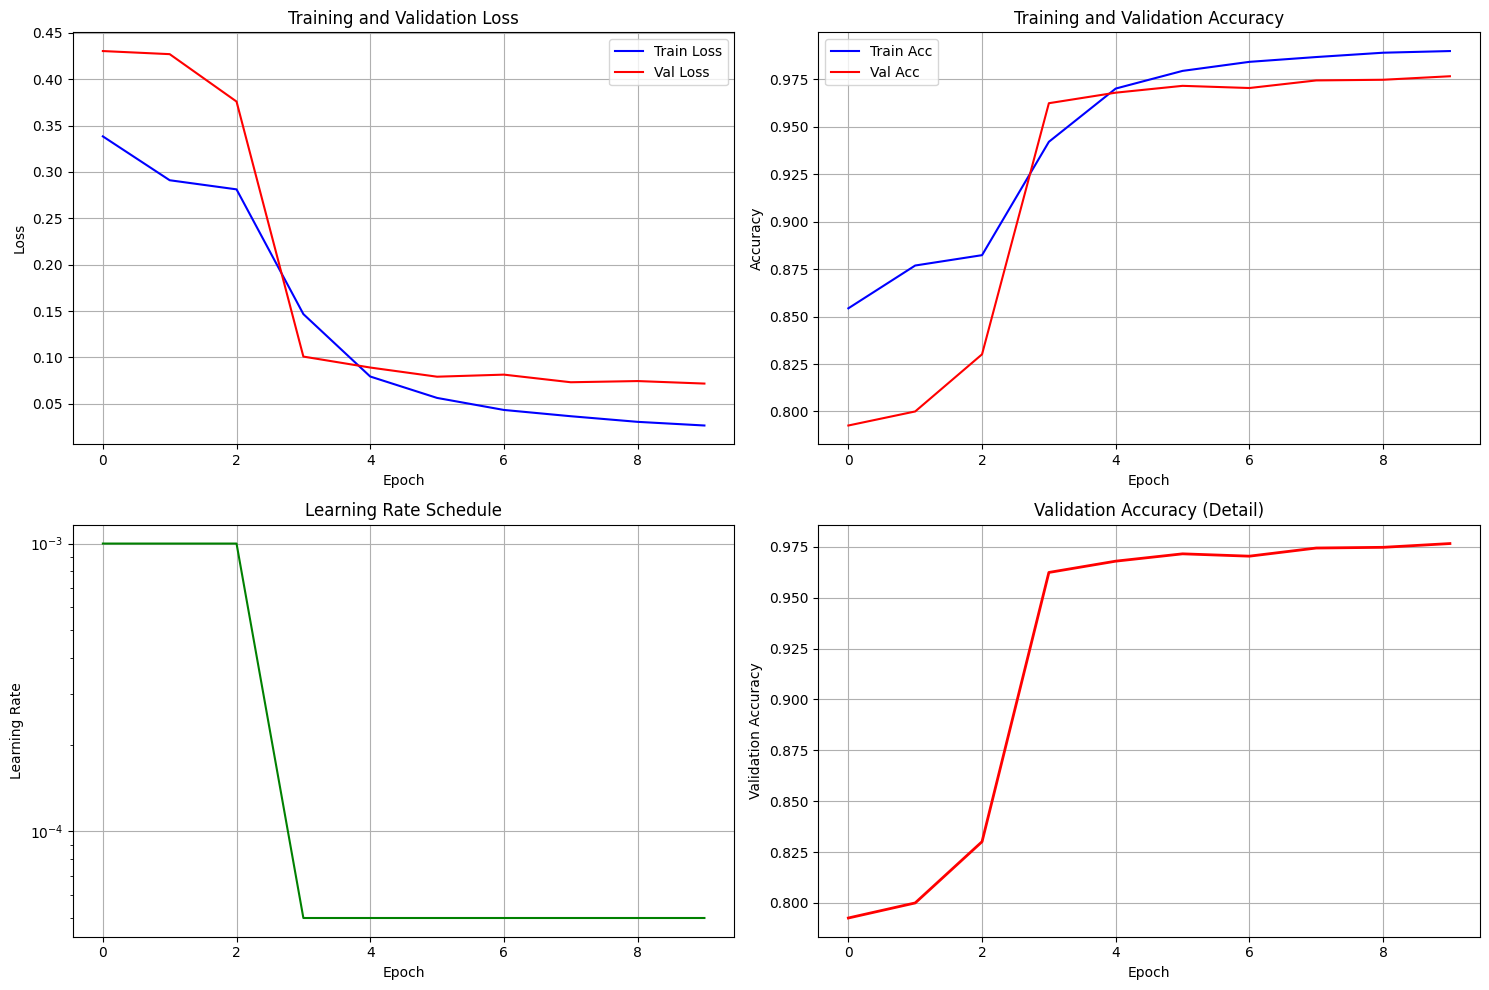

In [16]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning Rate
    axes[1, 0].plot(history['learning_rate'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)

    # Validation Accuracy (detailed)
    axes[1, 1].plot(history['val_acc'], color='red', linewidth=2)
    axes[1, 1].set_title('Validation Accuracy (Detail)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# test set với checkpoint tốt nhất
try:
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best model from epoch {ckpt['epoch']} with val_acc={ckpt['val_acc']:.4f}")
except FileNotFoundError:
    print("Model checkpoint not found. Using current model state.")
    print("Chạy training trước để tạo checkpoint.")

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

acc = accuracy_score(all_targets, all_preds)
cm = confusion_matrix(all_targets, all_preds)
print("Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print(classification_report(all_targets, all_preds, target_names=class_names))


Model checkpoint not found. Using current model state.
Chạy training trước để tạo checkpoint.


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipython-input-346069694.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Test Accuracy: 0.9774
Confusion Matrix:
 [[9795  205]
 [ 247 9753]]
              precision    recall  f1-score   support

        FAKE       0.98      0.98      0.98     10000
        REAL       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

